<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Data Science Immersive - Capstone Project

---

# Predicting delayed flights and improving operational performance  

## 03. Modelling  
<br/><br/>


***

## Table of Contents

* [4. Modelling](#4.-Modelling)
    * [4.1 Import libraries and data](#4.1-Import-libraries-and-data)
    * [4.2 Remove empty values](#4.2-Remove-empty-values)
    * [4.3 Dummify nominal variables](#4.3-Dummify-nominal-variables)
    * [4.4 Initial Model Testing](#4.4-Initial-Model-Testing)
    * [4.5 Gradient Boosting Classifier](#4.5-Gradient-Boosting-Classifier)
    * [4.6 Logistic Regression](#4.6-Logistic-Regression)
    * [3.7 Flight delays and weather](#3.7-Flight-delays-and-weather)  
<br/><br/>


***

# 4. Modelling

### 4.1 Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import warnings

In [2]:
# run to avoid warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set(font_scale=0.8)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve

### 4.2 Remove empty values

In [5]:
# load the data from CSV for consistency reasons
df = pd.read_csv('datasets/mod/df_01.csv', low_memory=False)

In [6]:
df.isnull().sum()

date                         0
year                         0
month                        0
day                          0
weekday                      0
hour                         0
departing                    0
terminal_num             59864
airline_code             11161
airline_name             11353
aircraft_type_code       57936
aircraft_type_name       57936
service_type                 0
domestic                     0
cancelled                    0
regular                      0
CIS_country                  0
country_name                 0
flight_number                4
main_delay_code         162033
source_delay            180400
runway                  126803
spot_number              57927
pax_total                72275
pax_1                        0
pax_2                        0
pax_3                        0
pax_4                        0
pax_5                        0
pax_6                        0
load_factor              12846
baggage_weight           74207
mail_wei

In [7]:
# drop columns and rows - 1st round
df.drop(columns=['main_delay_code', 'source_delay', 'runway'], inplace=True)
df.shape

(195293, 37)

In [8]:
df.isnull().sum()

date                         0
year                         0
month                        0
day                          0
weekday                      0
hour                         0
departing                    0
terminal_num             59864
airline_code             11161
airline_name             11353
aircraft_type_code       57936
aircraft_type_name       57936
service_type                 0
domestic                     0
cancelled                    0
regular                      0
CIS_country                  0
country_name                 0
flight_number                4
spot_number              57927
pax_total                72275
pax_1                        0
pax_2                        0
pax_3                        0
pax_4                        0
pax_5                        0
pax_6                        0
load_factor              12846
baggage_weight           74207
mail_weight             112335
temperature                  0
relative_humidity            0
apparent

In [9]:
# drop columns and rows - 2nd round
df.drop(columns=['date', 'flight_number', 'mail_weight'], inplace=True)
df.shape

(195293, 34)

In [10]:
df.isnull().sum()

year                        0
month                       0
day                         0
weekday                     0
hour                        0
departing                   0
terminal_num            59864
airline_code            11161
airline_name            11353
aircraft_type_code      57936
aircraft_type_name      57936
service_type                0
domestic                    0
cancelled                   0
regular                     0
CIS_country                 0
country_name                0
spot_number             57927
pax_total               72275
pax_1                       0
pax_2                       0
pax_3                       0
pax_4                       0
pax_5                       0
pax_6                       0
load_factor             12846
baggage_weight          74207
temperature                 0
relative_humidity           0
apparent_temperature        0
precipitation               0
weather_code                0
wind_speed                  0
delayed   

In [11]:
df[df.isnull().sum(axis=1)>0]
# The row drop operation seems more feasible now

,year,month,day,weekday,hour,departing,terminal_num,airline_code,airline_name,aircraft_type_code,...,pax_6,load_factor,baggage_weight,temperature,relative_humidity,apparent_temperature,precipitation,weather_code,wind_speed,delayed
1,2013,1,1,1,3,0.0,1,OZ,ASIANA AIRLINES,74Y,...,0,NaN,NaN,0.9,94,-2.4,0.0,3,13.0,1
3,2013,1,1,1,6,1.0,1,OZ,ASIANA AIRLINES,74Y,...,0,NaN,NaN,0.7,94,-3.3,0.0,3,18.1,0
7,2013,1,1,1,9,1.0,2,NaN,NaN,CJ3,...,0,NaN,NaN,1.0,92,-3.7,0.1,71,21.0,0
20,2013,1,1,1,12,0.0,2,NaN,NaN,H80,...,0,NaN,NaN,1.1,94,-3.3,0.6,73,19.5,0
21,2013,1,1,1,12,0.0,2,AY,FINNAIR,320,...,0,0.0,NaN,1.1,94,-3.3,0.6,73,19.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195283,2013,12,31,1,22,1.0,NaN,FV,ROSSIYA AIRLINES,NaN,...,0,100.0,NaN,1.2,84,-2.8,0.0,2,16.1,0
195284,2013,12,31,1,22,0.0,NaN,SU,AEROFLOT,NaN,...,0,100.0,NaN,1.2,84,-2.8,0.0,2,16.1,0
195285,2013,12,31,1,22,0.0,NaN,SU,AEROFLOT,NaN,...,0,100.0,NaN,1.2,84,-2.8,0.0,2,16.1,0
195287,2013,12,31,1,22,0.0,3,NaN,NaN,C30,...,0,NaN,NaN,1.2,84,-2.8,0.0,2,16.1,0


In [12]:
df.dropna(axis=0, how='any', inplace=True)
df.shape

(119613, 34)

In [13]:
df.isnull().sum()

year                    0
month                   0
day                     0
weekday                 0
hour                    0
departing               0
terminal_num            0
airline_code            0
airline_name            0
aircraft_type_code      0
aircraft_type_name      0
service_type            0
domestic                0
cancelled               0
regular                 0
CIS_country             0
country_name            0
spot_number             0
pax_total               0
pax_1                   0
pax_2                   0
pax_3                   0
pax_4                   0
pax_5                   0
pax_6                   0
load_factor             0
baggage_weight          0
temperature             0
relative_humidity       0
apparent_temperature    0
precipitation           0
weather_code            0
wind_speed              0
delayed                 0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119613 entries, 0 to 195291
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  119613 non-null  int64  
 1   month                 119613 non-null  int64  
 2   day                   119613 non-null  int64  
 3   weekday               119613 non-null  int64  
 4   hour                  119613 non-null  int64  
 5   departing             119613 non-null  float64
 6   terminal_num          119613 non-null  object 
 7   airline_code          119613 non-null  object 
 8   airline_name          119613 non-null  object 
 9   aircraft_type_code    119613 non-null  object 
 10  aircraft_type_name    119613 non-null  object 
 11  service_type          119613 non-null  object 
 12  domestic              119613 non-null  float64
 13  cancelled             119613 non-null  float64
 14  regular               119613 non-null  float64
 15  

### 4.3 Dummify nominal variables

In [15]:
# dummify nominal variables
df_dum = pd.get_dummies(df, drop_first=True)
df_dum

,year,month,day,weekday,hour,departing,domestic,cancelled,regular,CIS_country,...,spot_number_9,spot_number_93,spot_number_94,spot_number_97,spot_number_97A,spot_number_98,spot_number_99,spot_number_G20-A,spot_number_АНГ,spot_number_ЗАВ
0,2013,1,1,1,3,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2013,1,1,1,5,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2013,1,1,1,7,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,2013,1,1,1,9,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,2013,1,1,1,9,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195286,2013,12,31,1,22,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
195288,2013,12,31,1,22,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
195289,2013,12,31,1,22,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
195290,2013,12,31,1,22,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# save the modified dataframe as CSV
df_dum.to_csv('datasets/mod/df_dum.csv', encoding='utf-8', index=False)

In [17]:
# load the data from CSV for consistency reasons
df_dum = pd.read_csv('datasets/mod/df_dum.csv', low_memory=False)

In [18]:
# define target and predictors
y = df_dum.pop('delayed')
X = df_dum

#### Baseline accuracy

In [19]:
# determine baseline accuracy
print('Baseline accuracy:', y.value_counts(normalize=True).max())

Baseline accuracy: 0.7375452500982335


In [20]:
# split the data into a train and a hold-out test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [21]:
# instantiate a standar scaler, fit on the train set, and transform both the train and 
# test sets. I fit only on the train set, so that the test set remains 'unseen' data.

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns) 
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### 4.4 Initial Model Testing

Since my target is categorical, I need to fit a classification model.  
Below I test ten different classification models using `sklearn`:

    01. Logistic Regression model  
    02. K-Nearest Neighbours Classifier  
    03. Decision Tree Classifier  
    04. Random Forest Classifier  
    05. Extra Trees Classifier  
    06. Support Vector Machine Classifier
    07. AdaBoost Classifier
    08. Gradient Boosting Classifier
    09. Naïve Bayes Classifier
    10. MLP Classifier  
<br/><br/>



In [22]:
# set up a function to test different models 
def test_models(models, names, x_train, x_test, y_train, y_test): 
    
    """
    Print train, test and cross-validated train scores for different models 
    Arguments:
    models: List of models to test
    names: List of model names as strings
    x_train, x_test: x values to train and test the model on
    y_train, y_test: y values to train and test the model on
    """
    
    for model, name in list(zip(models, names)): 
        m = model
        m.fit(x_train, y_train)
        print(name)
        print()
        print('Train score:         ', m.score(x_train, y_train))
        print('Test score:          ', m.score(x_test, y_test))
        print('Cross-val mean score:', cross_val_score(m, x_test, y_test, cv=5).mean())
        print('-'*40)
        print()
        print()

In [23]:
models = [LogisticRegression(max_iter=5000), 
          KNeighborsClassifier(n_neighbors=5), 
          DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=1), 
          RandomForestClassifier(max_depth=3, random_state=1),
          ExtraTreesClassifier(n_estimators=100, random_state=1),
          SVC(kernel='rbf', gamma='scale', random_state=1),
          AdaBoostClassifier(n_estimators=100, random_state=1),
          GradientBoostingClassifier(learning_rate=0.2, max_depth=5, random_state=1),
          GaussianNB(),
          MLPClassifier(solver='adam', alpha=10**(0), hidden_layer_sizes=(8, 8, 8, 8, 8), activation='relu',
                    random_state=1, batch_size=50, max_iter=500)]

names = ['Logistic Regression', 'KNN Classifier', 'Decision Tree Classifier', 'Random Forest Classifier',
         'Extra Trees Classifier', 'Kernel SVM Classifier', 'AdaBoost Classifier', 'Gradient Boosting Classifier',
         'Naïve Bayes Classifier', 'MLP Classifier']

In [24]:
test_models(models, names, X_train, X_test, y_train, y_test)

Logistic Regression

Train score:          0.7644058940328143
Test score:           0.7640346110437655
Cross-val mean score: 0.7619031830238726
----------------------------------------


KNN Classifier

Train score:          0.8227923502978368
Test score:           0.7529156042302387
Cross-val mean score: 0.7389126940026489
----------------------------------------


Decision Tree Classifier

Train score:          0.7552513324276309
Test score:           0.7531664088952055
Cross-val mean score: 0.7488194801200798
----------------------------------------


Random Forest Classifier

Train score:          0.7375483331591598
Test score:           0.7375329181122768
Cross-val mean score: 0.7375329206026359
----------------------------------------


Extra Trees Classifier

Train score:          1.0
Test score:           0.7879446557705974
Cross-val mean score: 0.7750281677343146
----------------------------------------


Kernel SVM Classifier

Train score:          0.7767791827777197
Test sco

#### Best performing model
The best performing model is the **Gradient Boosting Classifier**.   
We are going to investigate this model further using `GridSearchCV`.
  
  ***

### 4.5 Gradient Boosting Classifier

In [25]:
# define hyperparemeters
gbc_params = {'learning_rate': [0.01, 0.2, 1, 10, 100],
              'n_estimators': [5, 50, 100, 250, 500],
              'max_depth': [1, 3, 5, 9, None],
              'min_samples_leaf': [1, 3, 7],
              'max_features': [10, 50, 'sqrt']}

# define the model 
gbc = GradientBoostingClassifier(random_state=1)

# instantiate the grid search 
gbc_gridsearch = GridSearchCV(gbc, gbc_params, n_jobs=10, cv=5, verbose=1, return_train_score=True)

# find the fit in the grid search 
gbc_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1125 candidates, totalling 5625 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=10,
             param_grid={'learning_rate': [0.01, 0.2, 1, 10, 100],
                         'max_depth': [1, 3, 5, 9, None],
                         'max_features': [10, 50, 'sqrt'],
                         'min_samples_leaf': [1, 3, 7],
                         'n_estimators': [5, 50, 100, 250, 500]},
             return_train_score=True, verbose=1)

In [26]:
gbc_gridsearch.param_grid

{'learning_rate': [0.01, 0.2, 1, 10, 100],
 'n_estimators': [5, 50, 100, 250, 500],
 'max_depth': [1, 3, 5, 9, None],
 'min_samples_leaf': [1, 3, 7],
 'max_features': [10, 50, 'sqrt']}

In [27]:
gbc_gridsearch.best_score_

0.7956421778660256

**Best estimator**

In [28]:
gbc_gridsearch.best_estimator_

GradientBoostingClassifier(learning_rate=0.01, max_depth=None, max_features=50,
                           min_samples_leaf=7, n_estimators=500,
                           random_state=1)

In [29]:
gbc_gridsearch.best_params_

{'learning_rate': 0.01,
 'max_depth': None,
 'max_features': 50,
 'min_samples_leaf': 7,
 'n_estimators': 500}

#### Final Model
We assign the best fit model (`best_estimator_`) to a variable and score it on the train and test data.  

***

In [30]:
best_gbc = gbc_gridsearch.best_estimator_

print('Gradient Boosting Classifier')
print()
print('Train score:         ', best_gbc.score(X_train, y_train))
print('Test score:          ', best_gbc.score(X_test, y_test))
print('Cross-val mean score:', cross_val_score(best_gbc, X_test, y_test, cv=5).mean())
print('Cross-val scores:    ', cross_val_score(best_gbc, X_test, y_test, cv=5))

Gradient Boosting Classifier

Train score:          0.9999163966976695
Test score:           0.7973080299293567
Cross-val mean score: 0.7805460206959457
Cross-val scores:     [0.78098224 0.77951933 0.77868339 0.78177258 0.78177258]


The final test score is **0.7973** while the cross validated score is slightly lower at **0.7805**.

***

#### Features importance  
One way to understand the model is checking the score given to the different features, where this score represent the importance of each one.  
A higher score means that the specific feature will have a larger effect on the model when predicting a certain variable.  

***

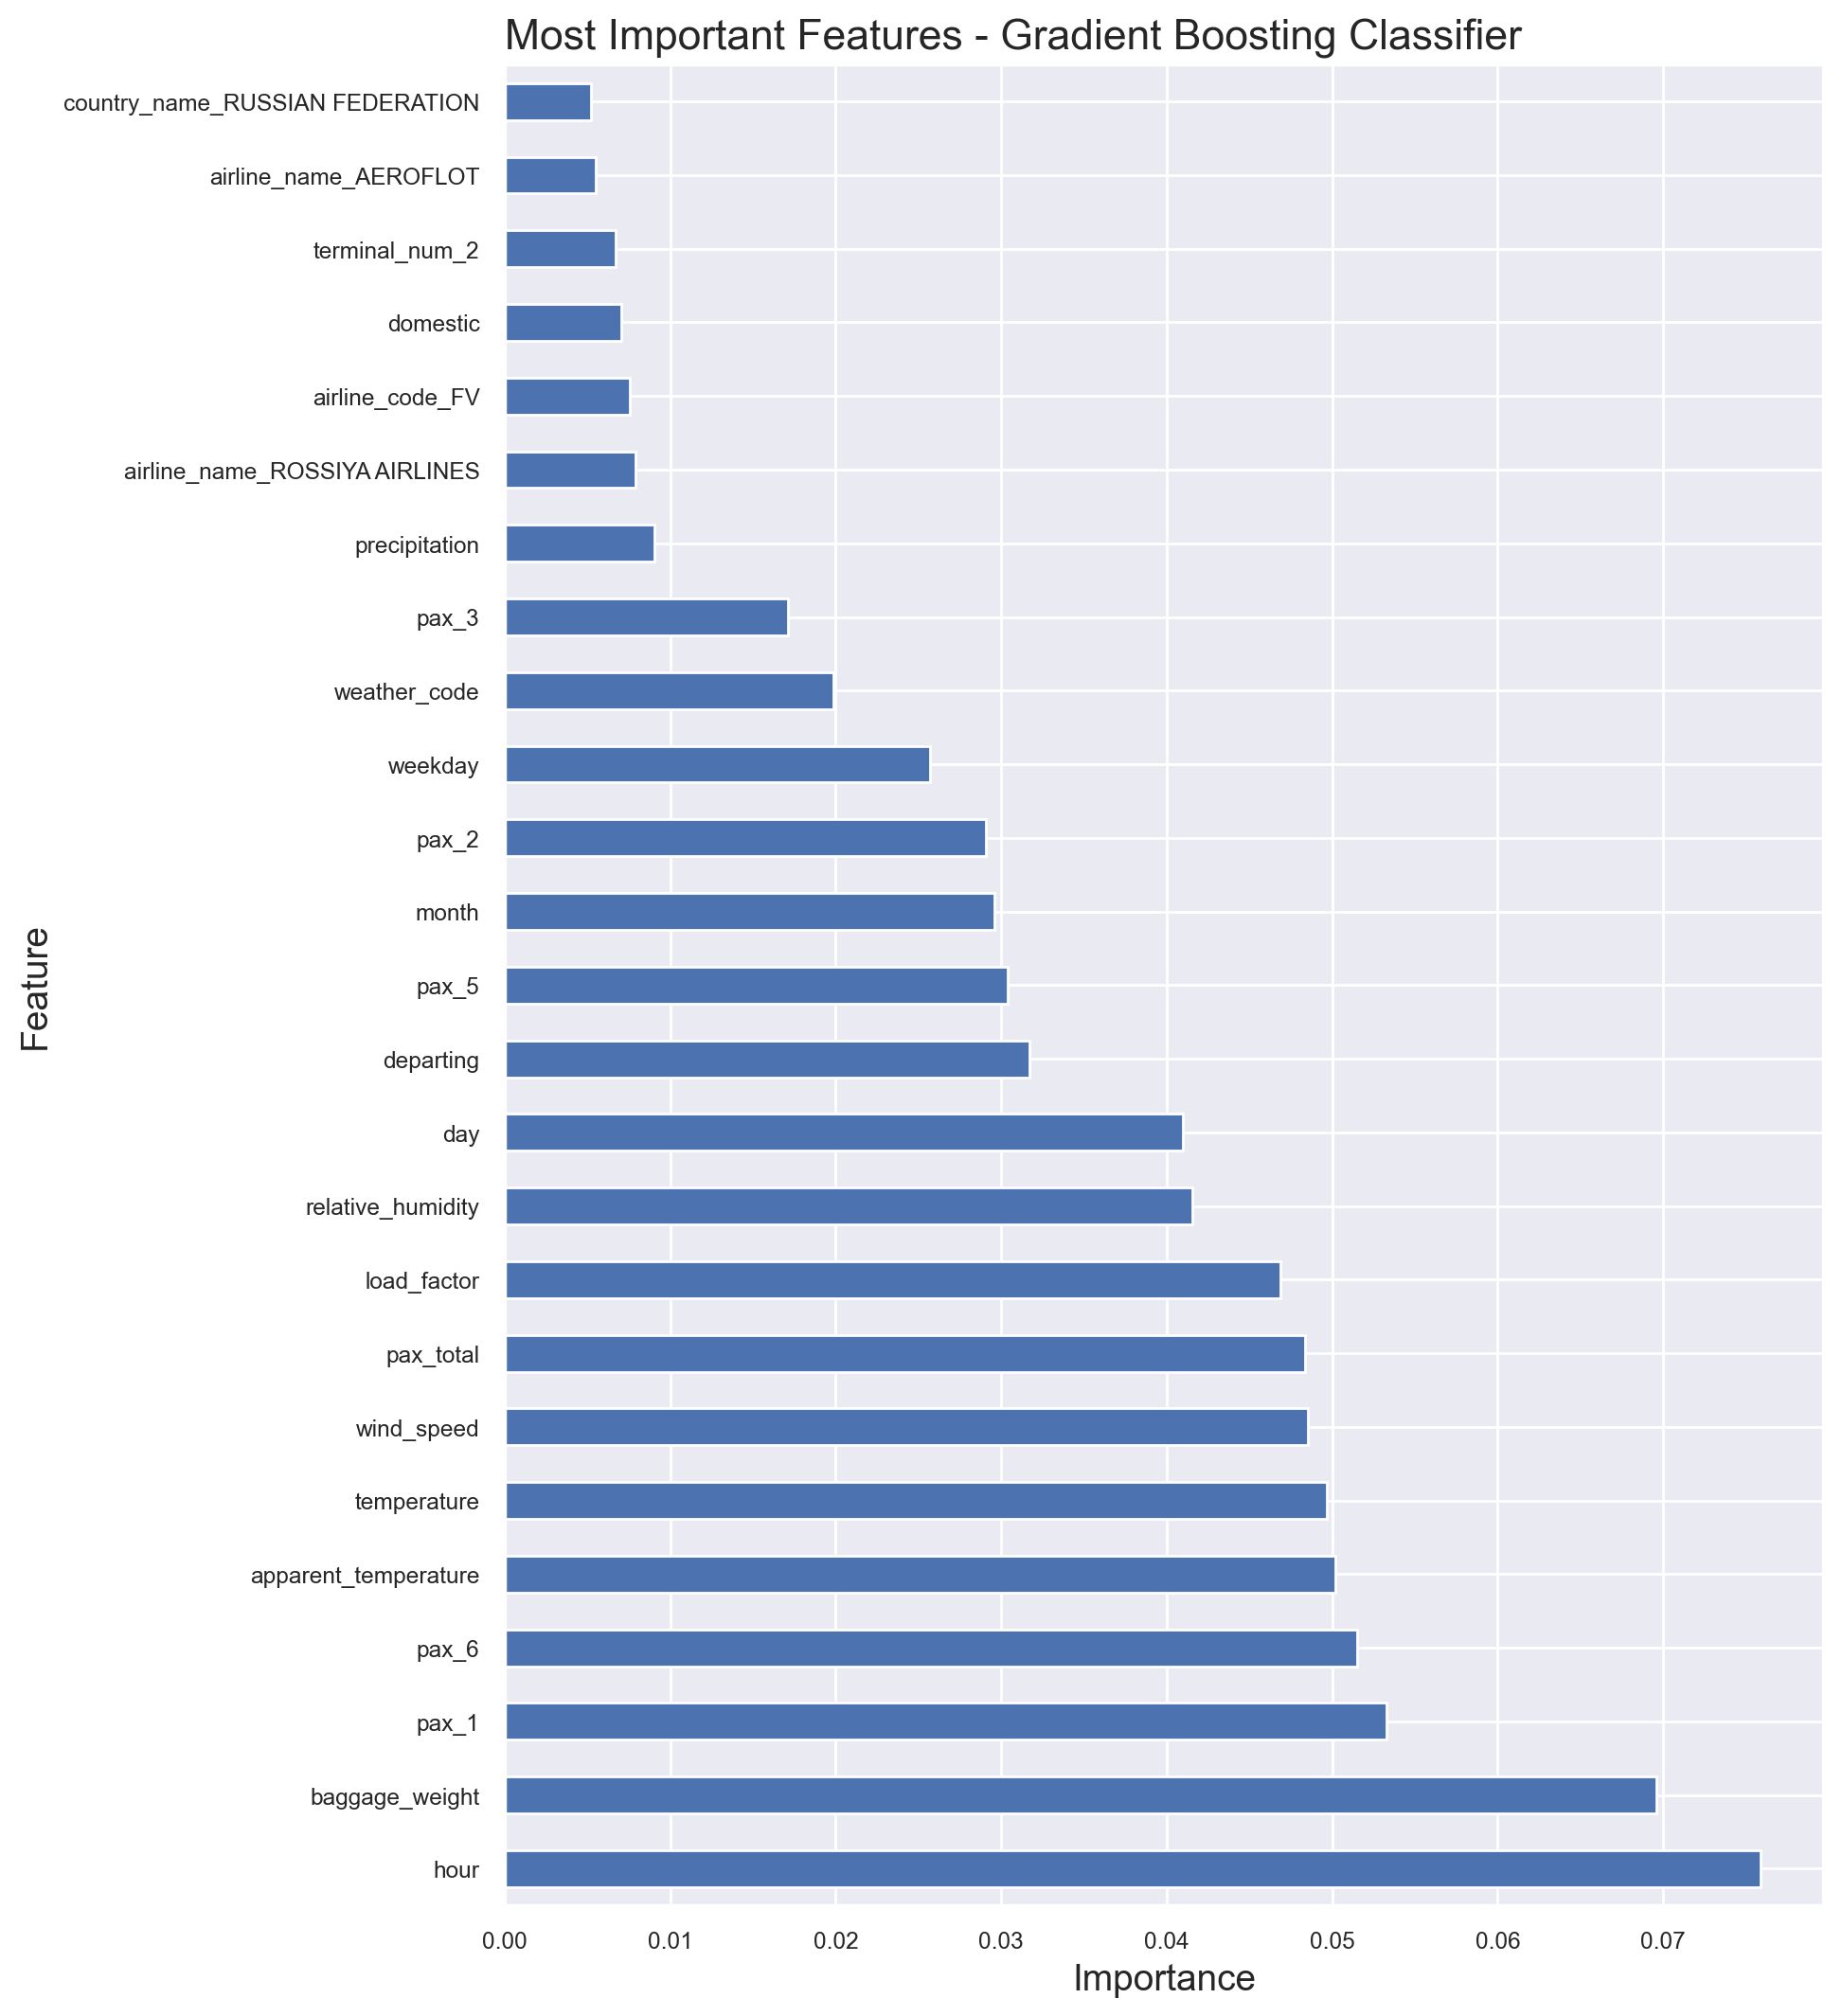

In [32]:
plt.title('Most Important Features - Gradient Boosting Classifier', loc='left', fontsize = 16)
plt.ylabel('Feature', fontsize = 14)
plt.xlabel('Importance', fontsize = 14)
(pd.Series(best_gbc.feature_importances_, index=X.columns)
   .nlargest(25)
   .plot(kind='barh', figsize=(8,12)));

The most important feature is **hour**, followed by **baggage_weight** and **pax_1**: in general, the most important features are original predictors, rather than dummified ones.  
<br/><br/>
  

***

### Model Evaluation

In [34]:
pred_train = best_gbc.predict(X_train)
pred_test = best_gbc.predict(X_test)

#### Confusion Matrix

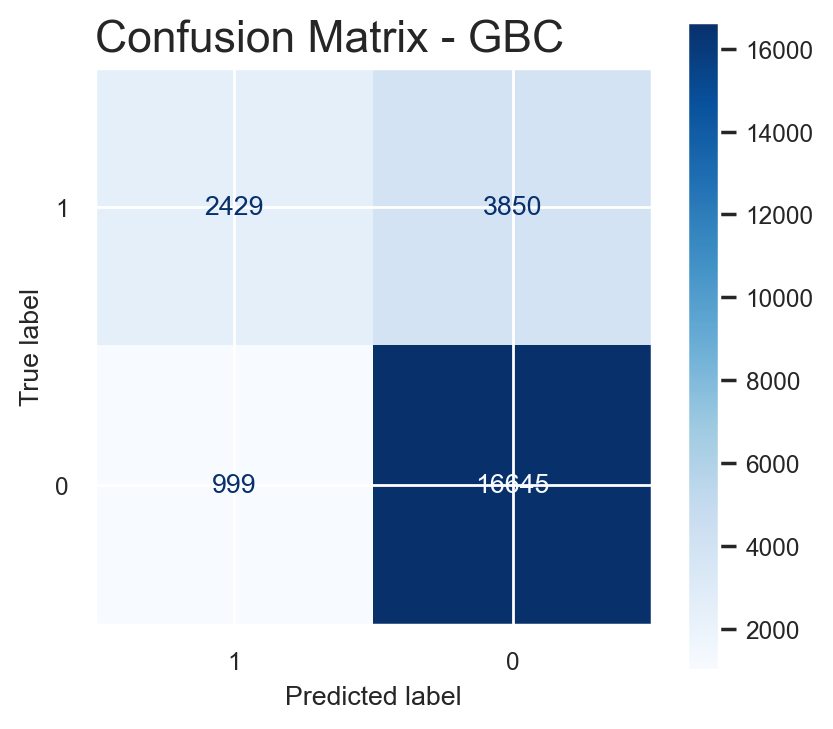

In [35]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_confusion_matrix(best_gbc, X_test, y_test, cmap='Blues', labels=[1, 0], ax=ax)
plt.title('Confusion Matrix - GBC', loc='left', fontsize = 16)
plt.show()

#### Classification Report

In [36]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70576
           1       1.00      1.00      1.00     25114

    accuracy                           1.00     95690
   macro avg       1.00      1.00      1.00     95690
weighted avg       1.00      1.00      1.00     95690



In [37]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87     17644
           1       0.71      0.39      0.50      6279

    accuracy                           0.80     23923
   macro avg       0.76      0.67      0.69     23923
weighted avg       0.78      0.80      0.78     23923



#### Receiver Operator Characteristic Curve

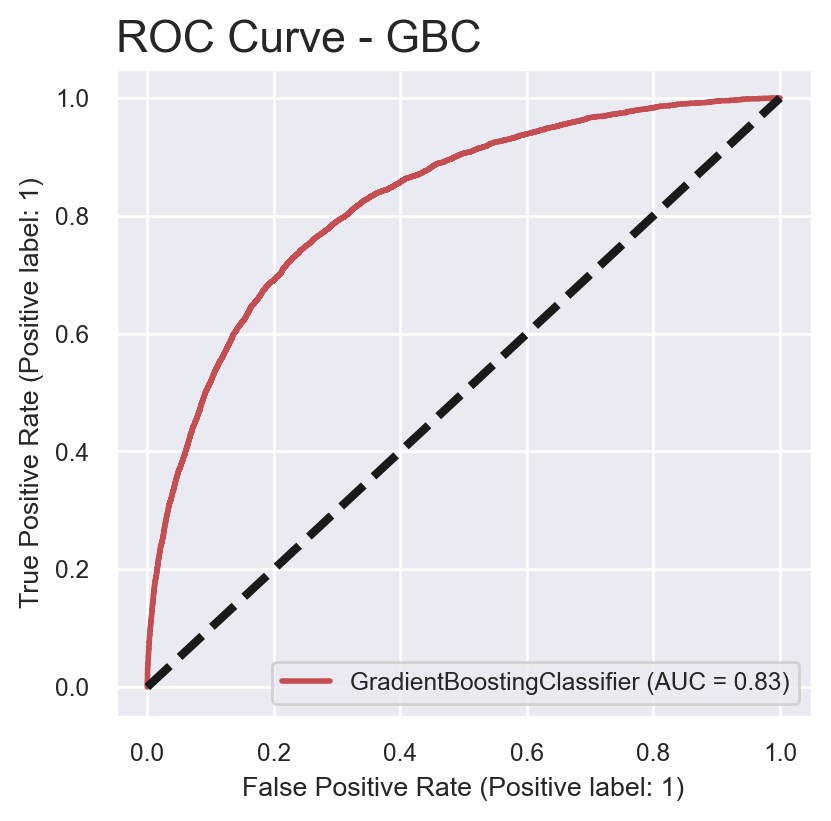

In [38]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_roc_curve(best_gbc, X_test, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve - GBC', loc='left', fontsize = 16)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [39]:
print('ROC-AUC Score:', roc_auc_score(y_test, best_gbc.predict_proba(X_test)[:, 1]))

ROC-AUC Score: 0.8252225836254894


#### Precision-Recall Curve

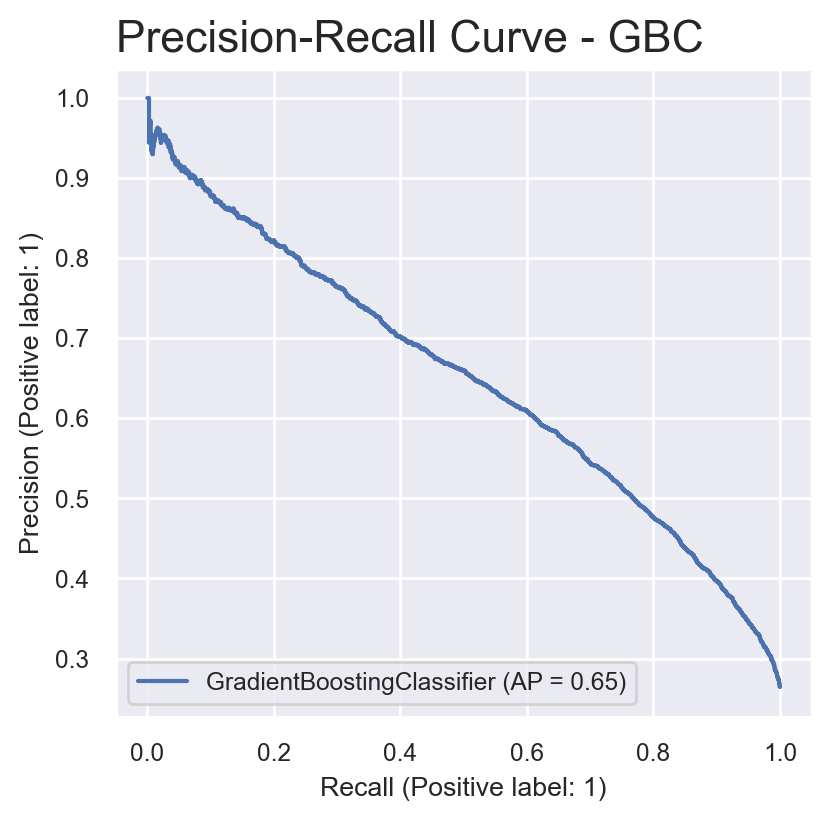

In [40]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_precision_recall_curve(best_gbc, X_test, y_test, ax=ax)
plt.title('Precision-Recall Curve - GBC', loc='left', fontsize = 16)
plt.show()

A critical step after implementing a machine learning algorithm is to find out how effective our model is based on metrics and datasets.  
  
  
The Confusion Matrix is not entirely a performance metric but provides a basis on which other metrics can evaluate the results.  
In our example there are two rather unbalanced classes (baseline is **0.7375**) and the matrix shows clearly that the model is biased towards the **majority class (0)** which is then **overpredicted**.  

The Classification Report confirms the unbalanced behaviour of the model.  
The majority class has a good precision score and a very good recall score.  
The minority class has an average precision score and a bad recall score.  
  
  The ROC-AUC Score is **0.83**, which tells us that the model has a fairly good class separation capacity.  
  The precision-recall curve shows the tradeoff between precision and recall for different threshold; here the PR-AUC is **0.65**, the curve descends in an atypical monotonic fashion, and the precision decreases significantly at **0.70** when recall is around **0.40**.  
  <br/><br/>
  





#### Second best performing model
The second best performing model is the **Logistic regression**.  
We are going to investigate this model further using `GridSearchCV`.  
  
  ***

### 4.6 Logistic Regression

In [22]:
# define hyperparameters
logreg_params = {'penalty': ['l1', 'l2', 'elasticnet'],
                 'solver': ['saga'],
                 'C': [100, 10, 1.0, 0.1, 0.01]}

# define the model
logreg = LogisticRegression(max_iter = 1000)

# instantiate the grid search
logreg_gridsearch = GridSearchCV(logreg, logreg_params, cv=5)

# find the fit in the grid search
logreg_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['saga']})

In [23]:
logreg_gridsearch.param_grid

{'penalty': ['l1', 'l2', 'elasticnet'],
 'solver': ['saga'],
 'C': [100, 10, 1.0, 0.1, 0.01]}

In [24]:
logreg_gridsearch.best_score_

0.7620963528059359

**Best estimator**

In [25]:
logreg_gridsearch.best_estimator_

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='saga')

In [26]:
logreg_gridsearch.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}

#### Final Model
We assign the best fit model (`best_estimator_`) to a variable and score it on the train and test data.  

***

In [27]:
best_logr = logreg_gridsearch.best_estimator_

print('Logistic Regression')
print()
print('Train score:         ', best_logr.score(X_train, y_train))
print('Test score:          ', best_logr.score(X_test, y_test))
print('Cross-val mean score:', cross_val_score(best_logr, X_test, y_test, cv=5).mean())
print('Cross-val scores:    ', cross_val_score(best_logr, X_test, y_test, cv=5))

Logistic Regression

Train score:          0.7641759849514056
Test score:           0.764996028926138
Cross-val mean score: 0.7624046805268694
Cross-val scores:     [0.76259143 0.75945664 0.75799373 0.76693144 0.76505017]


In [28]:
# collect the model coefficients in a dataframe
logr_coef = pd.DataFrame(best_logr.coef_[0], index=X_train.columns, columns=['coefficients'])
logr_coef.sort_values(by = 'coefficients', ascending = False)[:10]

,coefficients
pax_6,0.443060
baggage_weight,0.269902
load_factor,0.223014
temperature,0.190005
hour,0.151255
airline_code_LH,0.081038
airline_name_LUFTHANSA,0.081038
airline_code_SU,0.078238
airline_name_AEROFLOT,0.078238
airline_name_AK BARS AERO,0.077602


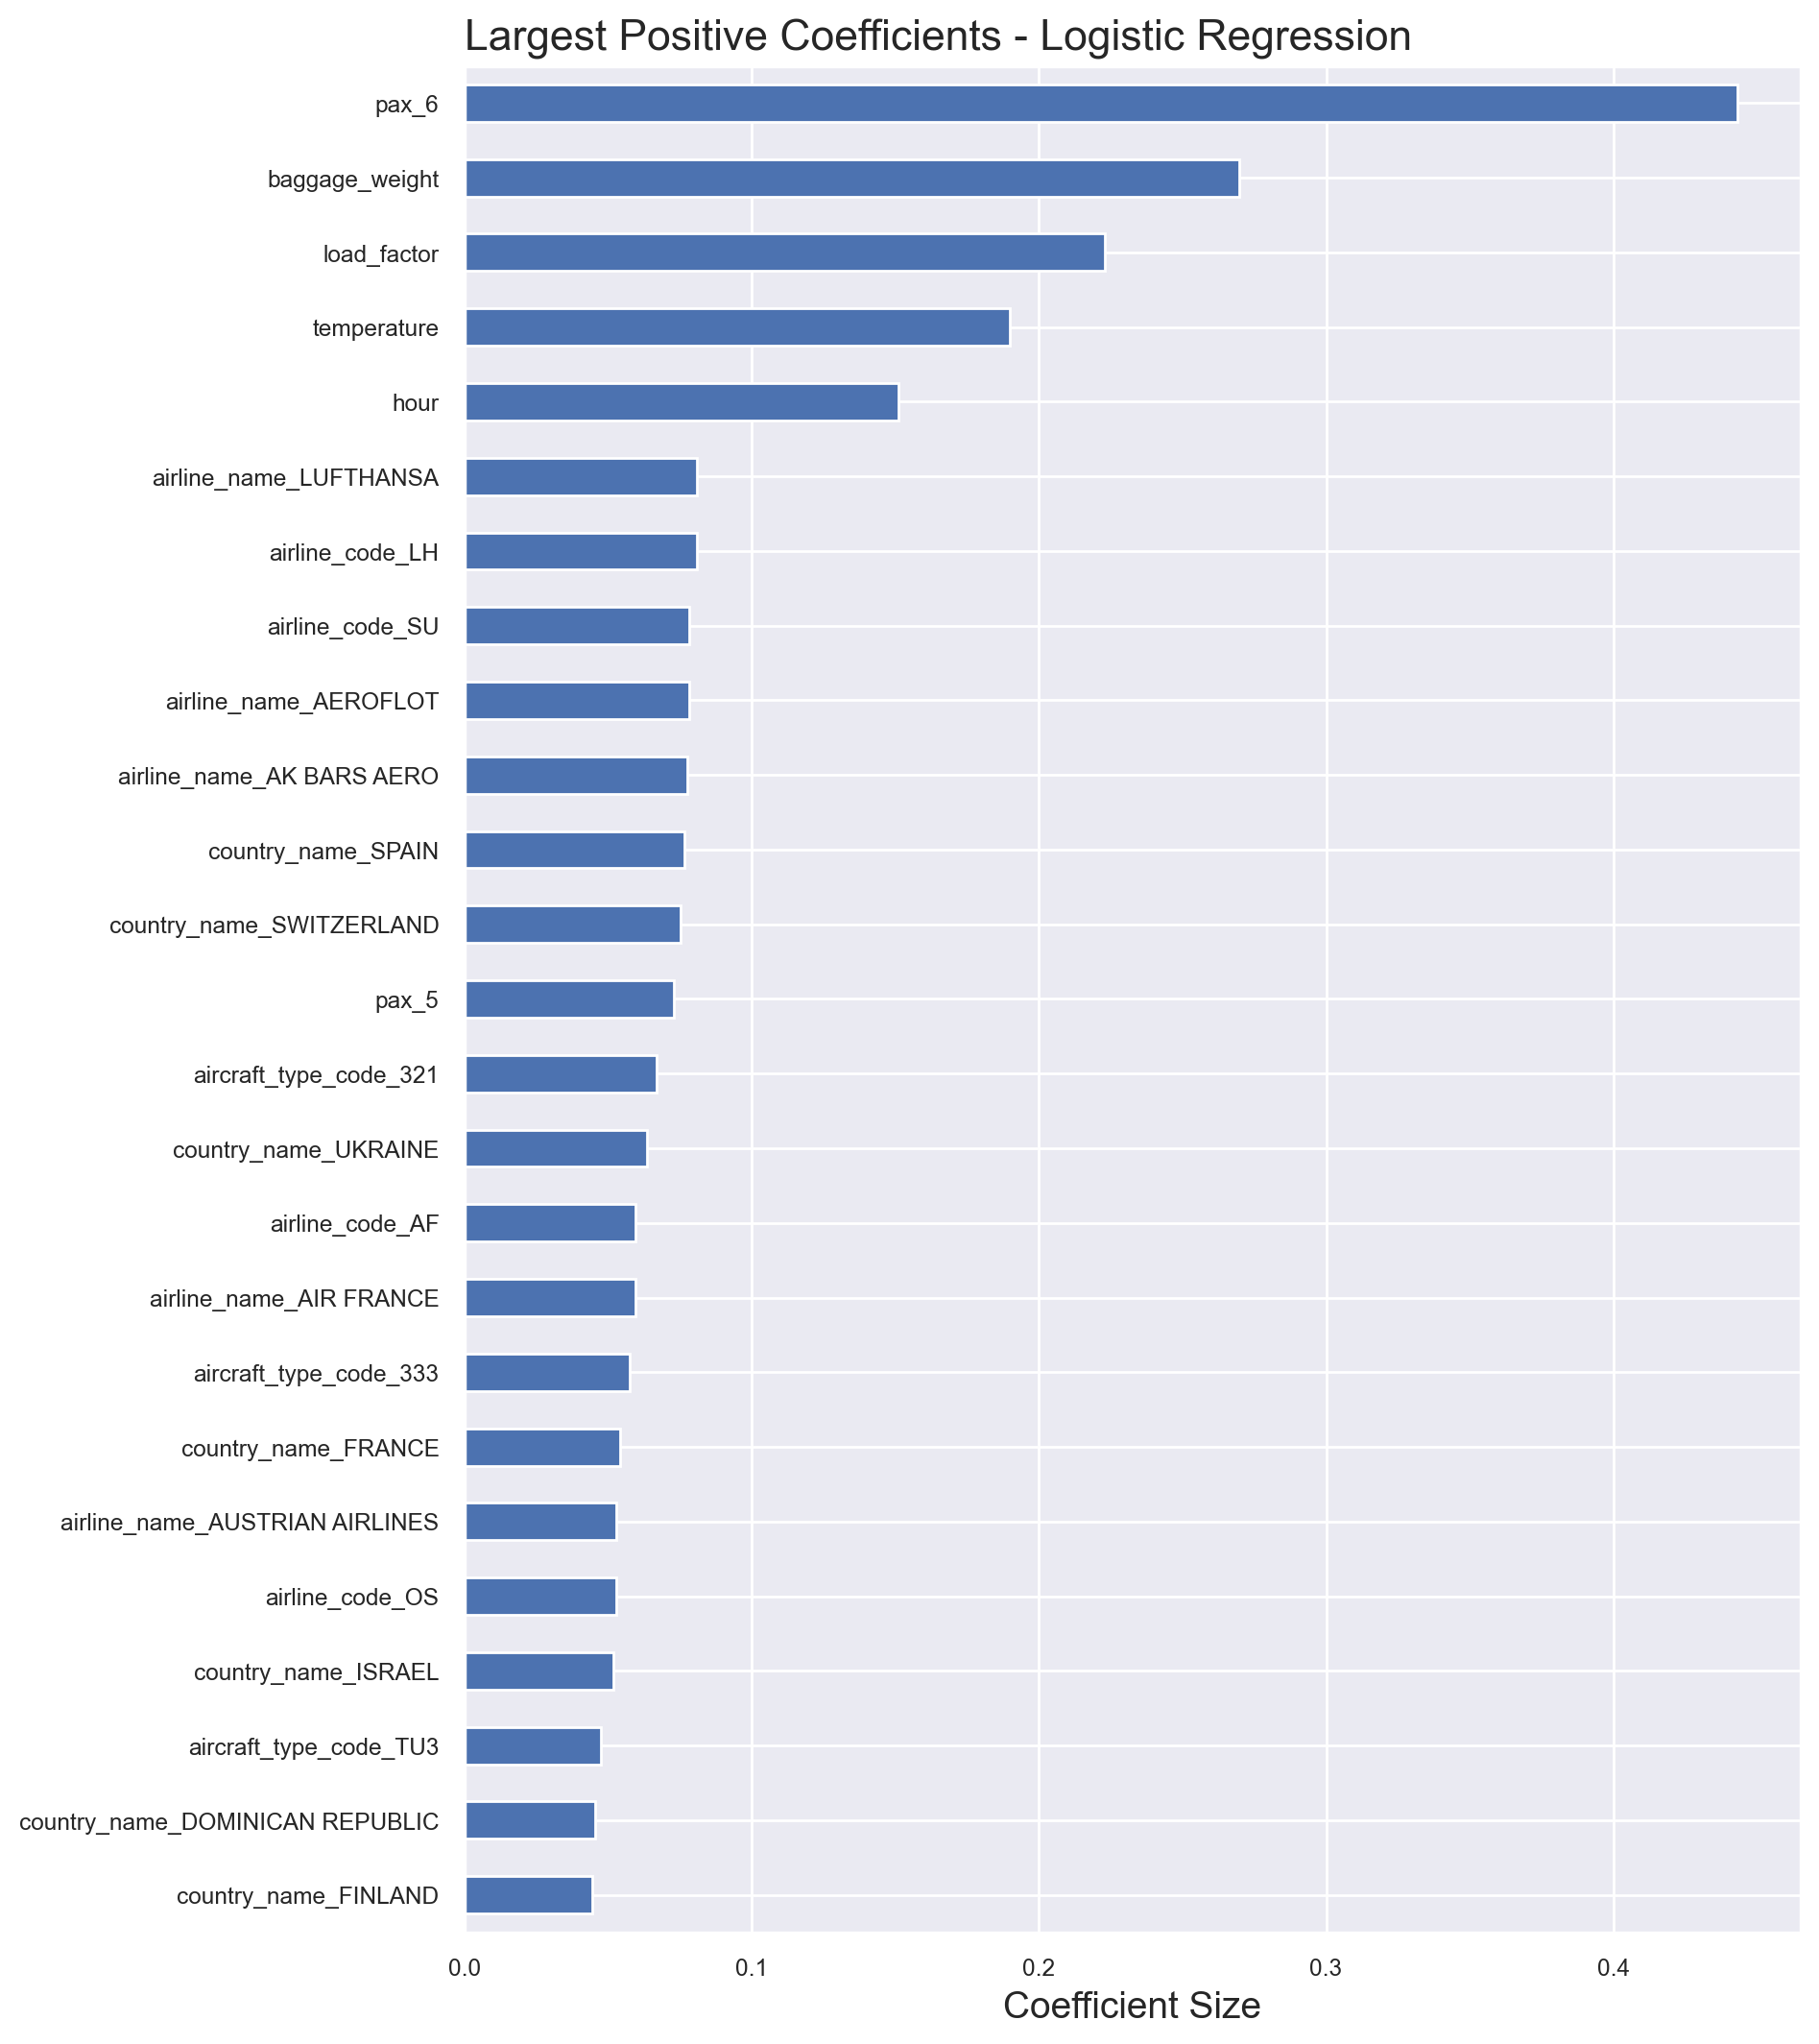

In [29]:
plt.figure(figsize=(8,12))
plt.title('Largest Positive Coefficients - Logistic Regression', loc='left', fontsize = 16)
plt.xlabel('Coefficient Size', fontsize = 14)

logr_coef['coefficients'].sort_values(ascending = True).tail(25).plot(kind='barh');

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

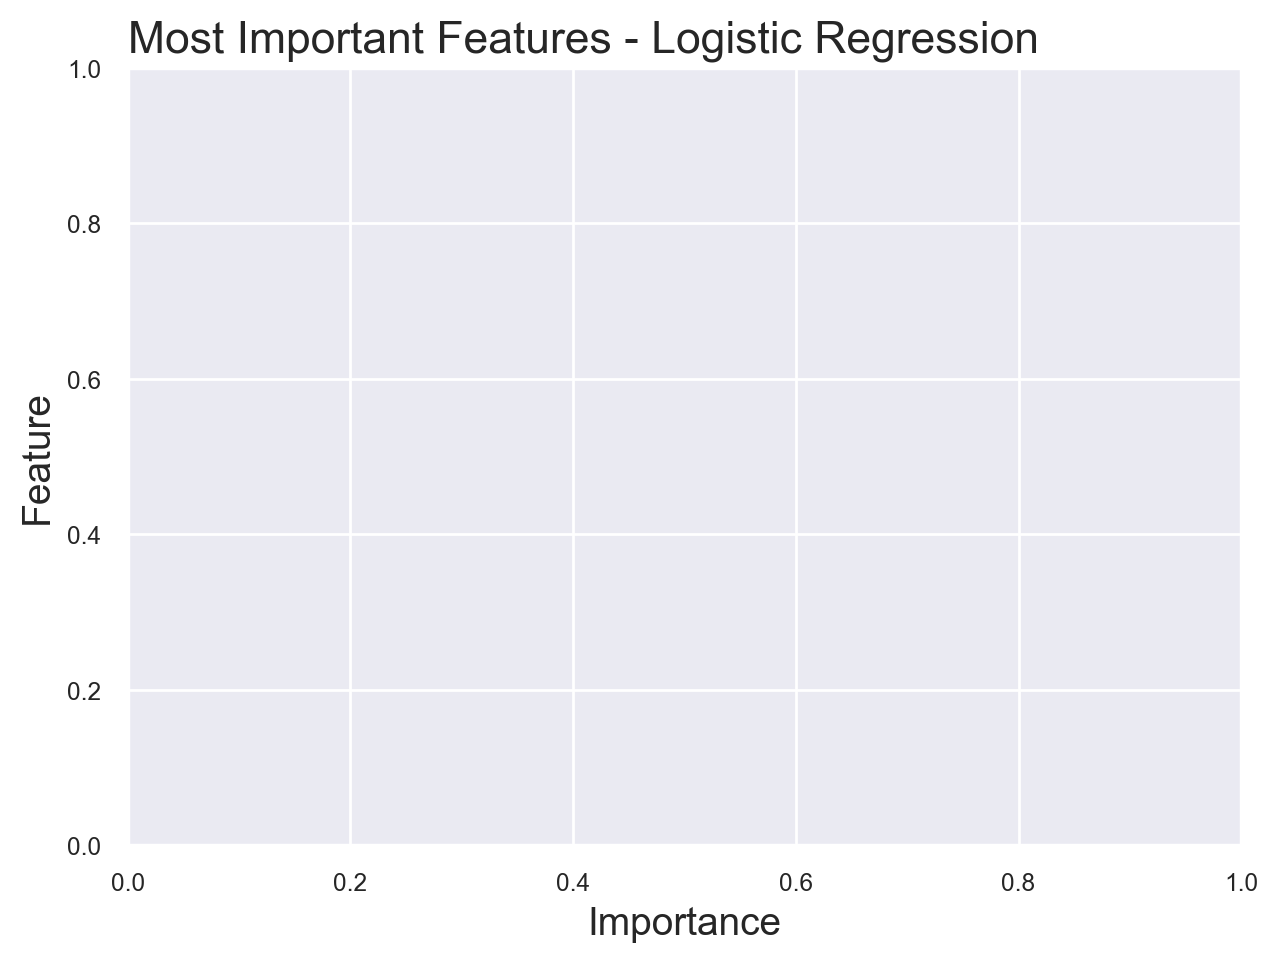

In [28]:
plt.title('Most Important Features - Logistic Regression', loc='left', fontsize = 16)
plt.ylabel('Feature', fontsize = 14)
plt.xlabel('Importance', fontsize = 14)
(pd.Series(best_logr.feature_importances_, index=X.columns)
   .nlargest(25)
   .plot(kind='barh', figsize=(8,12)));